<a href="https://colab.research.google.com/github/AtomZa/Bioinformatics/blob/main/tr/design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TrDesign in JAX!
Backprop through TrRosetta for protein design.

In [1]:
#@title install
%%bash
if [ ! -d params/tr ]; then
  # get code
  pip -q install git+https://github.com/sokrypton/ColabDesign.git@v1.1.0

  # for debugging
  ln -s /usr/local/lib/python3.7/dist-packages/colabdesign colabdesign

  # download params
  mkdir -p params/tr
  wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/models.zip -P params/tr/
  wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/bkgr_models.zip -P params/tr/
  unzip -qqo params/tr/models.zip -d params/tr/
  unzip -qqo params/tr/bkgr_models.zip -d params/tr/
  rm params/tr/models.zip 
  rm params/tr/bkgr_models.zip

fi

In [2]:
#@title import libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from colabdesign import *
from google.colab import files
from IPython.display import HTML
import os
import numpy as np

def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  else:
    os.system(f"wget -qnc https://files.rcsb.org/view/{pdb_code}.pdb")
    return f"{pdb_code}.pdb"

#Hallucination

In [3]:
clear_mem()
tr_model = mk_trdesign_model(protocol="hallucination")
tr_model.prep_inputs(length=100)

In [4]:
tr_model.restart()
tr_model.set_opt(hard=False)
tr_model.design(50, verbose=10, save_best=False)
tr_model.set_opt(hard=True)
tr_model.design(50, verbose=10, save_best=True)

10 models [3] bkg -0.82
20 models [1] bkg -0.96
30 models [4] bkg -0.99
40 models [1] bkg -1.03
50 models [2] bkg -1.00
60 models [3] bkg -0.77
70 models [2] bkg -0.76
80 models [2] bkg -0.73
90 models [4] bkg -0.95
100 models [3] bkg -0.93


{'bkg': -0.9349777698516846}
['PKEEQEAEQKLQQALNEIQNAINELMNSNECFCFIFDGKIKEVVPCKNPGQCKVKDPNDGEIVPINPNDPVEECNKKGPDAEPIAIFPFPPGTCICIVMP']


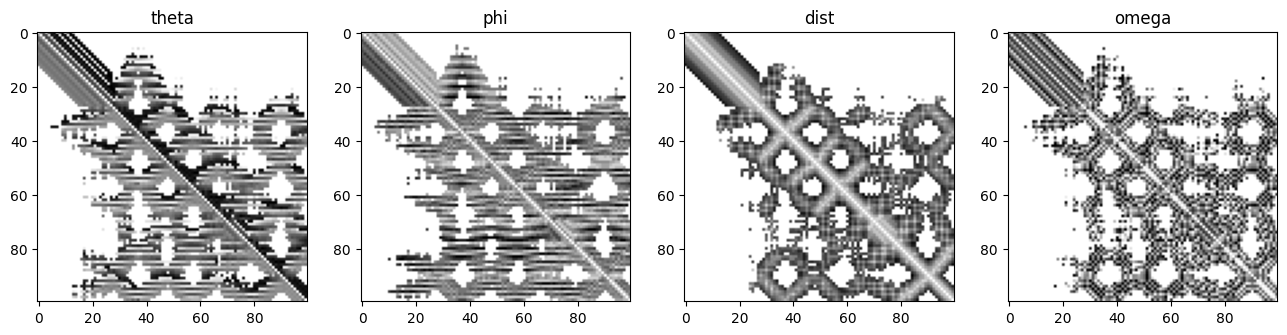

In [5]:
print(tr_model.get_loss())
print(tr_model.get_seq())
tr_model.plot("preds")

#fixbb

In [6]:
clear_mem()
tr_model = mk_trdesign_model(protocol="fixbb")
tr_model.prep_inputs(get_pdb("1TEN"),chain="A")

In [7]:
tr_model.restart()
tr_model.set_opt(hard=False)
tr_model.design(50, verbose=10, save_best=False)
tr_model.set_opt(hard=True)
tr_model.design(50, verbose=10, save_best=True)

10 models [1] cce 1.84
20 models [1] cce 1.27
30 models [2] cce 1.20
40 models [0] cce 1.19
50 models [3] cce 1.13
60 models [1] cce 1.53
70 models [4] cce 1.39
80 models [3] cce 1.40
90 models [3] cce 1.39
100 models [1] cce 1.40


{'cce': 1.4040207862854004}
['MKPLPEIKIENNKPGQITIKCKPCPEPPKGIKIEICNPDDPGEKEEIVIPPGDPEITFNGLPPNCPFRLKVYVVDPDKLLEPDELCIPI']


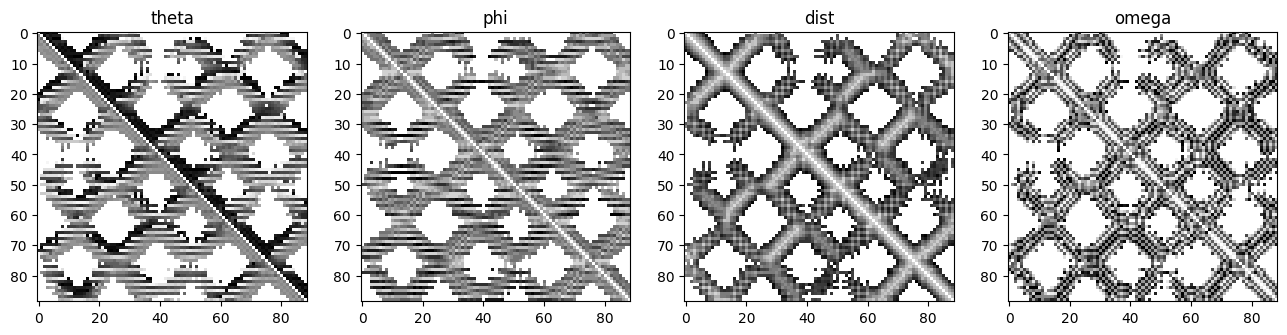

In [8]:
print(tr_model.get_loss())
print(tr_model.get_seq())
tr_model.plot("preds")

# combine with AfDesign

In [9]:
%%bash
if [ ! -d params/af ]; then
  # download alphafold weights
  mkdir -p params/af/params
  curl -fsSL https://storage.googleapis.com/alphafold/alphafold_params_2022-03-02.tar | tar x -C params/af/params
fi

### initialize with trdesign sequence

In [10]:
af_model = mk_afdesign_model(protocol="fixbb",data_dir="params/af")
af_model.prep_inputs(get_pdb("1TEN"))

In [11]:
af_model.restart(seq=tr_model.get_seq())
af_model.design_3stage(100,100,10)

Stage 1: running (logits → soft)
1 models [4] recycles 0 hard 0 soft 0.01 temp 1 seqid 0.13 loss 2.33 dgram_cce 2.33 plddt 0.70 ptm 0.48 rmsd 2.48
2 models [0] recycles 0 hard 0 soft 0.02 temp 1 seqid 0.13 loss 2.87 dgram_cce 2.87 plddt 0.43 ptm 0.23 rmsd 4.83
3 models [2] recycles 0 hard 0 soft 0.03 temp 1 seqid 0.13 loss 2.29 dgram_cce 2.29 plddt 0.69 ptm 0.50 rmsd 2.30
4 models [3] recycles 0 hard 0 soft 0.04 temp 1 seqid 0.13 loss 2.29 dgram_cce 2.29 plddt 0.72 ptm 0.52 rmsd 2.29
5 models [3] recycles 0 hard 0 soft 0.05 temp 1 seqid 0.13 loss 2.77 dgram_cce 2.77 plddt 0.43 ptm 0.24 rmsd 5.58
6 models [4] recycles 0 hard 0 soft 0.06 temp 1 seqid 0.13 loss 2.27 dgram_cce 2.27 plddt 0.70 ptm 0.49 rmsd 2.50
7 models [2] recycles 0 hard 0 soft 0.07 temp 1 seqid 0.13 loss 2.15 dgram_cce 2.15 plddt 0.73 ptm 0.55 rmsd 2.04
8 models [2] recycles 0 hard 0 soft 0.08 temp 1 seqid 0.13 loss 2.10 dgram_cce 2.10 plddt 0.76 ptm 0.58 rmsd 1.92
9 models [0] recycles 0 hard 0 soft 0.09 temp 1 seqid 0

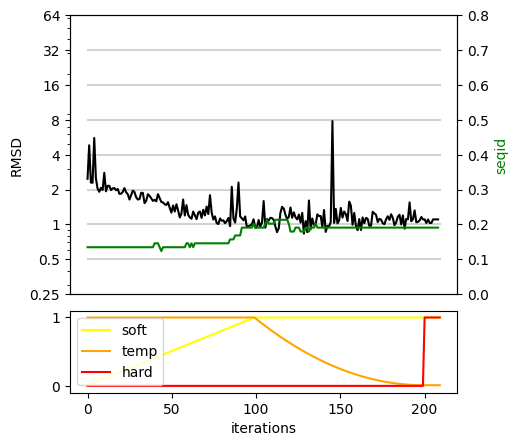

In [12]:
af_model.plot_traj()

In [13]:
af_model.plot_pdb()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### let's try a joint optimization

In [14]:
af_model.restart()
af_model.design_3stage(100,100,10, callback=tr_model.af_callback())

Stage 1: running (logits → soft)
1 models [2] recycles 0 hard 0 soft 0.01 temp 1 seqid 0.06 loss 9.00 dgram_cce 5.98 plddt 0.61 ptm 0.14 rmsd 35.36 TrD_cce 3.02
2 models [0] recycles 0 hard 0 soft 0.02 temp 1 seqid 0.04 loss 8.55 dgram_cce 5.99 plddt 0.91 ptm 0.46 rmsd 37.80 TrD_cce 2.56
3 models [3] recycles 0 hard 0 soft 0.03 temp 1 seqid 0.03 loss 7.54 dgram_cce 4.93 plddt 0.59 ptm 0.13 rmsd 36.90 TrD_cce 2.61
4 models [1] recycles 0 hard 0 soft 0.04 temp 1 seqid 0.04 loss 8.11 dgram_cce 5.65 plddt 0.72 ptm 0.38 rmsd 41.85 TrD_cce 2.46
5 models [2] recycles 0 hard 0 soft 0.05 temp 1 seqid 0.04 loss 8.07 dgram_cce 5.68 plddt 0.64 ptm 0.13 rmsd 35.79 TrD_cce 2.39
6 models [4] recycles 0 hard 0 soft 0.06 temp 1 seqid 0.01 loss 7.63 dgram_cce 5.30 plddt 0.68 ptm 0.14 rmsd 35.60 TrD_cce 2.34
7 models [1] recycles 0 hard 0 soft 0.07 temp 1 seqid 0.02 loss 6.27 dgram_cce 4.03 plddt 0.52 ptm 0.14 rmsd 30.46 TrD_cce 2.24
8 models [0] recycles 0 hard 0 soft 0.08 temp 1 seqid 0.03 loss 5.59 dg

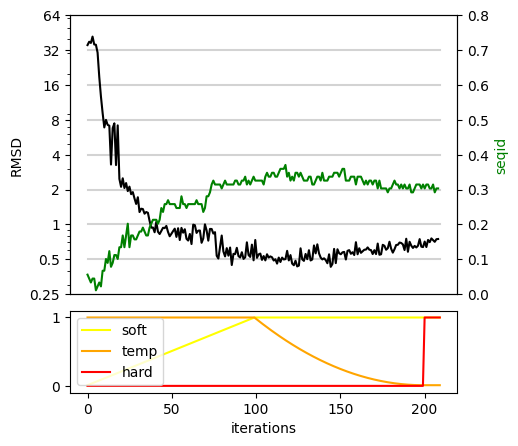

In [15]:
af_model.plot_traj()

In [16]:
af_model.plot_pdb()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [17]:
HTML(af_model.animate())

In [18]:
af_model.get_seqs()

['LEPLKNVEVSGVTDGSVTISWEPCDGPVDGVWISYHRAGDPGDCITHFLPADTTSFHITGLDPGTEYRVTLWCVSPGRMSEPQTIDFRI']